#### Imports


In [18]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal

#### Definitions

We define the discrete gradient operator $D$ and its adjoint $D^*$.

In [19]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]

In [20]:
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

We regularize the strongly convex primal problem by adding the corresponding LASSO term :
$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= f(x)+ g(Dx) + \alpha \lVert x \rVert_{1} =\frac{1}{2}\|x-y\|^2+\lambda\|Dx\|_{1,2} + \alpha \lVert x \rVert_{1}$$


Which is equivalent to

$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= \frac{1}{2}\|x-y\|^2+ h(x)$$

Where :

$$ h(x) = f(x) + g(x) $$
$$ f(x) = \lambda\|Dx\|_{1,2} = \lambda \cdot \text{TV(x)} $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

Therefore, we have to adapt the proximal operator for $h$, knowing that :

$$ x = \text{prox}_{\gamma h^*}(x) + \gamma \text{prox}_{h/\gamma}(x/\gamma) $$

$$ \text{prox}_{\gamma h}(x) =  \text{prox}_{\gamma g}(x) \circ \text{prox}_{\gamma f}(x)  $$

Thus yielding


$$\begin{aligned}

\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) \\
= u - \gamma \text{prox}_{g / \gamma}(\text{prox}_{f / \gamma}(u/\gamma) ) 
\end{aligned}$$

With

$$\text{prox}_{g/\gamma}(u) = \text{sign}(u) \cdot max\{0;|u| - 1/\alpha\} $$

$$  \text{prox}_{f/\gamma}(u) \ \text{defined numerically, using the pyproximal library.} $$

#### Definitions of the proximal operators

In [21]:
def proximal_operator_TV(x, gamma, Lambda):
    """  
    Applies the proximal operator of the TV term.
    
    Parameters
    ----------
    x : Multidim. array to which we apply the proximal operator. (np.ndarray)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    prox_result : The resulting ndarray from the application of the "TV" proximal operator.

    """
    #Defining the TV operator (that's how pyproximal works apparently)
    TV = pyproximal.TV(dims=x.shape, sigma=Lambda)
    try:
        #Apply the TV proximal operator to x/gamma, and reshape the result to what we need
        prox_result = TV.prox((x / gamma),2).reshape((512,512,2))
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

In [59]:
def proximal_operator_lasso(u, alpha):
    """  
    Applies the proximal operator of the L1 norm.
    
    Parameters
    ----------
    u : Multidim. array to which we apply the proximal operator. (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)

    Returns 
    ---------
    The resulting ndarray from the application of the L1 norm proximal operator.

    """
    #return np.sign(u) * np.maximum(abs(u) - alpha,0)
    L1 = pyproximal.L1(sigma=alpha)
    try:
        #Apply the TV proximal operator to x/gamma, and reshape the result to what we need
        prox_result = L1.prox((u),2).reshape((512,512,2))
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

#### Trying to use the original proximity operator instead :

We know that for $f(Dx) =  \lambda \ \lVert Dx \rVert_{1,2} $, we have 

$$\big(\text{prox}_{\gamma f^*}(u)\big)_{n_1,n_2}=\frac{1}{\max(\|u_{n_1,n_2}\|_2/\lambda,1)}u_{n_1,n_2}\in\mathbb{R}^2,\quad\forall (n_1,n_2).$$ 

Using the Moreau identity once again, and in the context of our newly defined problem, we can write 

$$

 \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \big(\text{prox}_{\gamma f^*}(u)\big) 
$$


$$
\Rightarrow \text{prox}_{f/\gamma}(u/\gamma) = \frac{u - \big(\text{prox}_{\gamma f^*}(u)\big)}{\gamma} 
$$

Knowing that $\big(\text{prox}_{\gamma f^*}(u)\big)$ is implemented as :


In [60]:
def prox_f_conj (u, Lambda) :
    return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

We can implement this proximal operator as :

In [61]:
def homemade_proximal_TV_operator(u,gamma,Lambda) : 
    return( (u - prox_f_conj(u,Lambda)) / gamma)

We can then implement both ways into the complete proximal operator :

In [62]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha, homemade=False):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:
        #Application of the proximal 'TV' operator, depending on the homemade arg.
        if homemade == True :
            prox_tv = homemade_proximal_TV_operator(redef_u, gamma, Lambda)
        elif homemade == False :
            prox_tv = proximal_operator_TV(redef_u, gamma, Lambda)
        #... And successive application of the proximal 'lasso' operator
        prox_lasso = proximal_operator_lasso(prox_tv, alpha)
        proximal_composition = gamma * prox_lasso

        return redef_u - proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

## Implementation + trying out the revised algorithm

In [63]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter,homemade=False) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u + x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = noised_image

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj((u)) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha,homemade)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


#### Generating the image + its noised version

C:\Users\dryha\AppData\Local\Temp\ipykernel_9624\1481045435.py:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  xsharp = misc.ascent()


Text(0.5, 1.0, 'Noisy version of Lena')

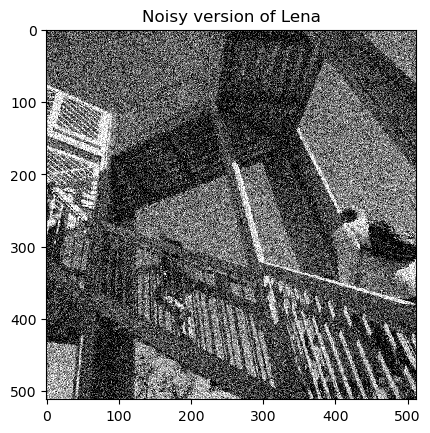

In [64]:
'''Generating input :'''
xsharp = misc.ascent()
xsharp = xsharp.astype(np.float32) #create image
'''Add Noise'''
(N1,N2) = np.shape(xsharp)
noiselevel = 50
noised_image = xsharp + noiselevel * np.random.randn(N1,N2)
plt.imshow(noised_image, interpolation='nearest', cmap= plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title('Noisy version of Lena')

In [161]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 50

xdenoised_wolasso,_,_  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter,True)
xdenoised_lasso,_,_ = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter,True)

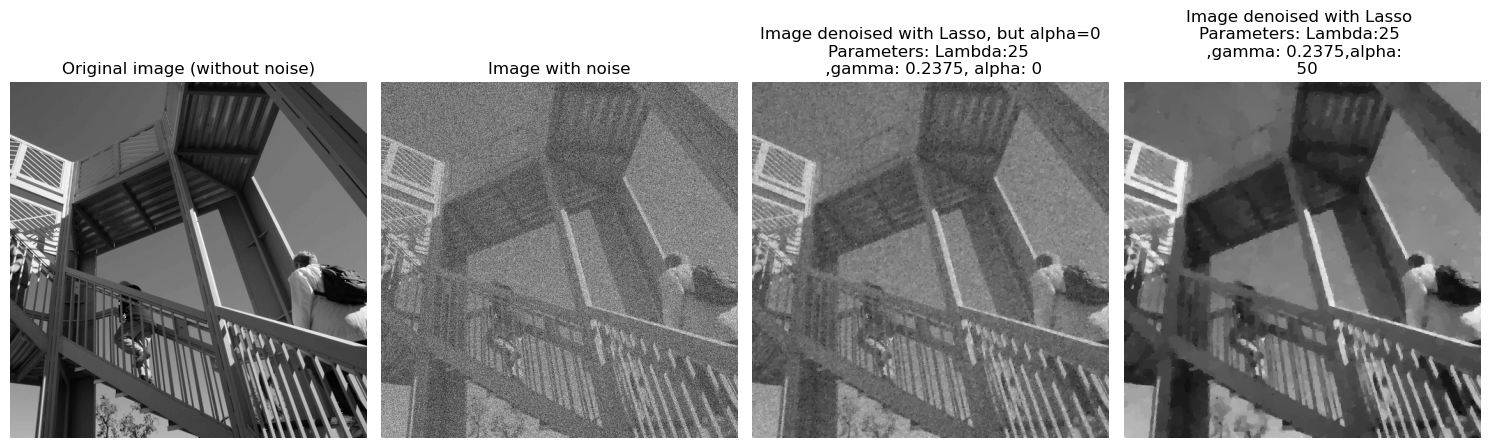

In [162]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(xdenoised_wolasso, cmap='gray')
axs[2].set_title(f"Image denoised with Lasso, but alpha=0\nParameters: Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[3].imshow(xdenoised_lasso, cmap='gray')
axs[3].set_title(f"Image denoised with Lasso \nParameters: Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Old plot of Ed/Ep arrays

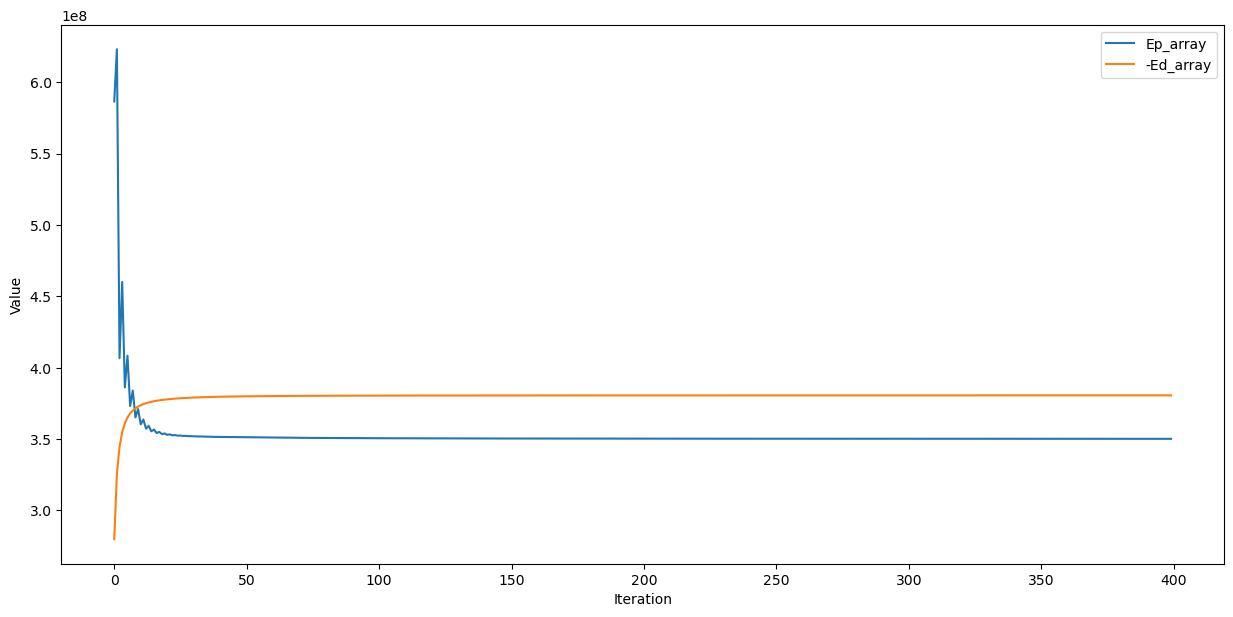

In [29]:
plt.figure(figsize=(15,7))
plt.plot(Ep_array, label='Ep_array')w
plt.plot(-Ed_array, label='-Ed_array')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')

# Show the plot
plt.show()

#### Trying to optimize hyperparameters

Best Parameters: {'Lambda': 40.0, 'alpha': 0.0, 'gamma': 0.2375}
Best PSNR: 24.80013436891005


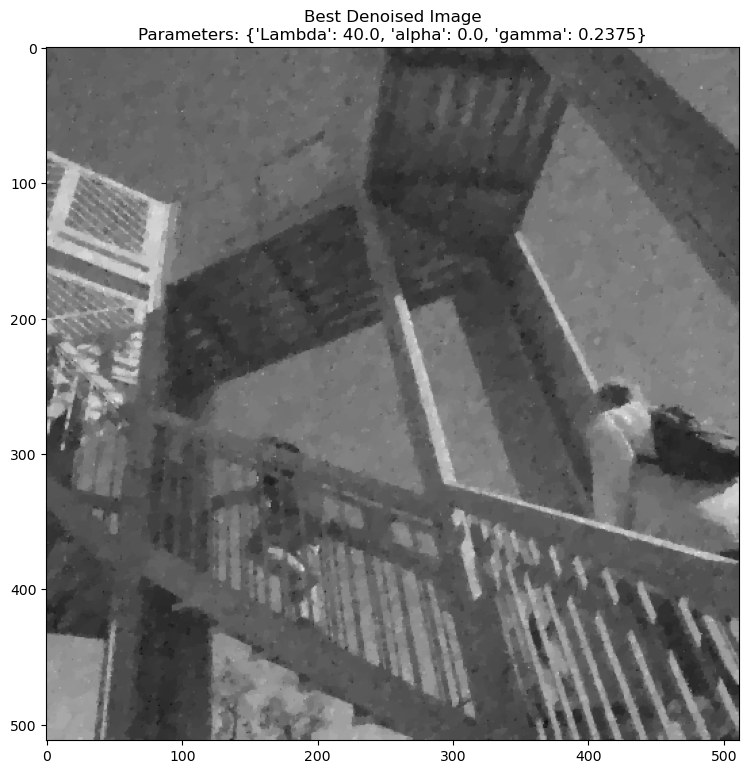

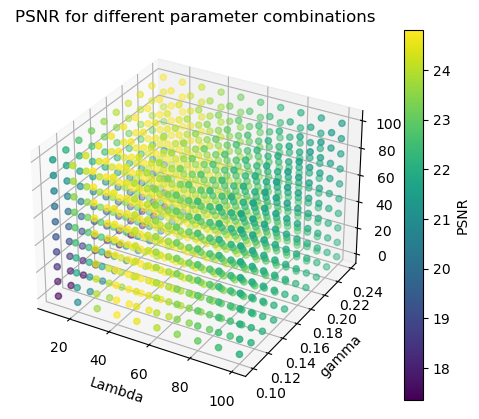

In [39]:
#from sklearn.model_selection import ParameterGrid
#from skimage.metrics import peak_signal_noise_ratio as psnr
#
#
#Lambda_values = np.linspace(10, 100, 10)  
#gamma_values = np.linspace(0.1, 1.9/8, 10)  
#alpha_values = np.linspace(0, 100, 10)  
#
#param_grid = {
#    'Lambda': Lambda_values,
#    'gamma': gamma_values,
#    'alpha': alpha_values,
#}
#
#param_combinations = list(ParameterGrid(param_grid))
#
#best_psnr = -np.inf
#best_params = None
#best_xdenoised = None
#
#psnr_values = []
#
#for params in param_combinations:
#    Lambda = params['Lambda']
#    gamma = params['gamma']
#    alpha = params['alpha']
#
#    xdenoised, Ep_array, Ed_array = chambolle_algorithm(noised_image, Lambda, gamma, alpha, nbiter, homemade=True)
#    
#    # Assuming `original_image` is the ground truth image without noise
#    #print(xdenoised,xsharp)
#    current_psnr = psnr(xsharp, xdenoised,data_range=255)
#    psnr_values.append((Lambda, gamma, alpha, current_psnr))
#    
#    if current_psnr > best_psnr:
#        best_psnr = current_psnr
#        best_params = params
#        best_xdenoised = xdenoised
#
#print(f"Best Parameters: {best_params}")
#print(f"Best PSNR: {best_psnr}")
#
## Visualize the best denoised image
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(9,9))
#plt.imshow(best_xdenoised, cmap='gray')
#plt.title(f"Best Denoised Image\nParameters: {best_params}")
#plt.show()
#
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#
## Unpack psnr values for plotting
#Lambda_vals, gamma_vals, alpha_vals, psnr_vals = zip(*psnr_values)
#
#sc = ax.scatter(Lambda_vals, gamma_vals, alpha_vals, c=psnr_vals, cmap='viridis')
#ax.set_xlabel('Lambda')
#ax.set_ylabel('gamma')
#ax.set_zlabel('alpha')
#plt.colorbar(sc, label='PSNR')
#plt.title('PSNR for different parameter combinations')
#plt.show()

#### Original Forward-Backward algorithm

In [ ]:
#Lambda = 25
#gamma = 1.9/8 # we must have 0 < gamma < 2/8
#nbiter = 400
#(N1,N2) = y.shape
#u = zeros([N1,N2,2])
#Ep_array = zeros(nbiter) # array for the primal energy E_p
#Ed_array = zeros(nbiter) # array for the dual energy E_d
#sqnormy = norm(y)**2/2
#for iter in range(nbiter):  
#    # put your code here
#    x=-Dadj((u))+y
#    u = prox_g_conj(u+gamma*D(x),Lambda)
#    Ep_array[iter] = norm(x-y)**2/2 + Lambda*sum(sqrt(sum(D(x)**2,2))) 
#    Ed_array[iter] = norm(y-Dadj(u))**2/2 - sqnormy
#xdenoised = x